In [116]:
import cv2 as cv

from matplotlib import pyplot as plt

In [117]:
src_image = cv.imread('images/win-1-01-16-47.jpg')
image = cv.cvtColor(src_image, cv.COLOR_RGB2GRAY)

In [118]:
win_text_template = cv.imread('templates/win.png', cv.IMREAD_GRAYSCALE)

In [119]:
from dataclasses import dataclass

import numpy as np


def threshold_match(
        match_result: np.ndarray,
        threshold: float,
) -> list[tuple[int, int, float]]:
    locations = np.where(match_result <= threshold)

    boxes = [(x, y, match_result[y, x]) for x, y in zip(locations[1], locations[0])]

    boxes.sort(key=lambda x: x[2])
    return boxes


@dataclass
class MatchingResult:
    x0: int
    y0: int
    w: int
    h: int
    score: float

    @property
    def x1(self) -> int:
        return self.x0 + self.w

    @property
    def y1(self) -> int:
        return self.y0 + self.h

    @property
    def top_left(self) -> tuple[int, int]:
        return self.x0, self.y0

    @property
    def bottom_right(self) -> tuple[int, int]:
        return self.x1, self.y1


def match_template(gray_img: np.ndarray,
                   gray_template: np.ndarray,
                   threshold: float) -> list[MatchingResult]:
    match_result = cv.matchTemplate(gray_img, gray_template, method=cv.TM_SQDIFF_NORMED)
    thr_match_result = threshold_match(match_result, threshold)

    template_w = gray_template.shape[1]
    template_h = gray_template.shape[0]

    result = [MatchingResult(x0=x, y0=y, w=template_w, h=template_h, score=score) for x, y, score in thr_match_result]
    return result


def crop_image(img: np.ndarray, x: int, y: int, w: int, h: int) -> np.ndarray:
    roi = img[y:y + h, x:x + w]
    return roi

In [120]:
def draw_matched_boxes(img: np.ndarray,
                       match_boxes: list[MatchingResult],
                       thickness: int = 1,
                       color: tuple[int, int, int] = (255, 0, 0)) -> None:
    for match_box in match_boxes:
        cv.rectangle(img, match_box.top_left, match_box.bottom_right, color, thickness)
    plt.figure(figsize=(20, 12))
    plt.imshow(img)


In [121]:
find_win_text = match_template(image, win_text_template, threshold=0.2)
win_text_box = find_win_text[0]


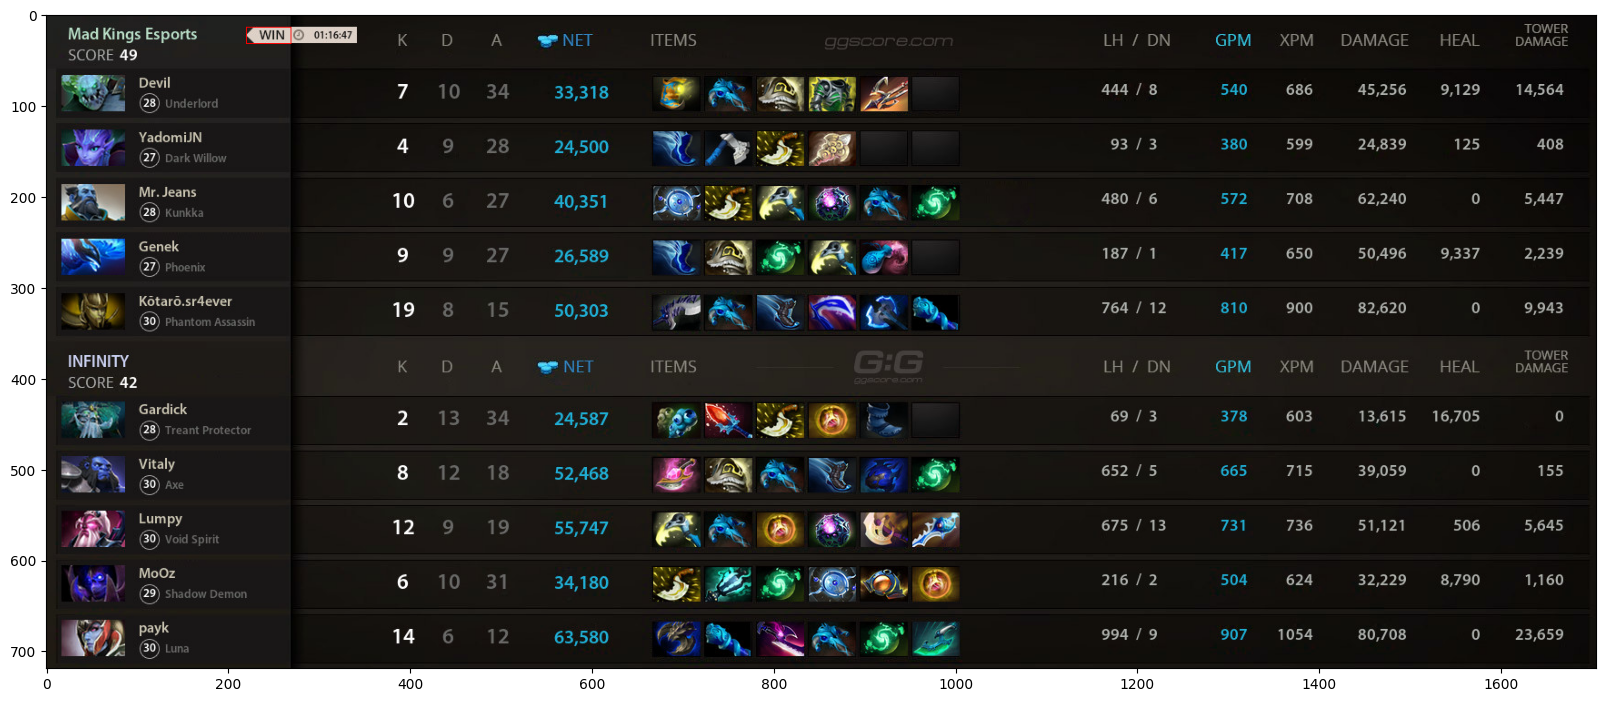

In [122]:
src_image_copy = src_image.copy()
draw_matched_boxes(src_image_copy, [win_text_box])

In [123]:
cropped_gray_time = crop_image(image, win_text_box.x0 + 70, win_text_box.y0, 50, win_text_box.h)
cropped_time = crop_image(src_image, win_text_box.x0 + 70, win_text_box.y0, 50, win_text_box.h)


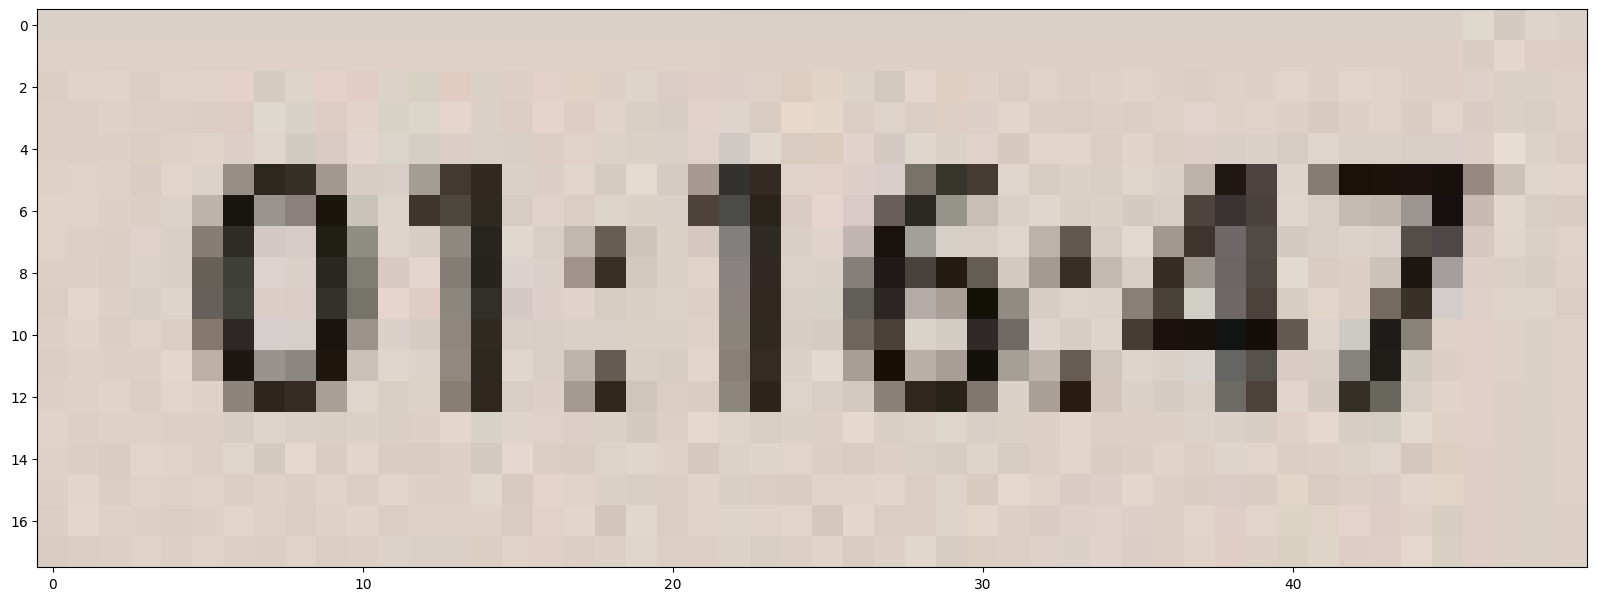

In [124]:
plt.figure(figsize=(20, 12))
plt.imshow(cropped_time)


In [125]:
cropped_time.shape

(18, 50, 3)

In [126]:
from pathlib import Path

digit_templates = {str(i): cv.imread(str(Path('templates') / f'{i}.png'), 0) for i in range(0, 10)}
colon_template = cv.imread(str(Path('templates') / 'colon.png'), 0)


In [127]:
@dataclass
class DigitMatchingResult:
    digit: str
    matching_result: MatchingResult


def match_digits(time_gray_img: np.ndarray,
                 digit_templates_dict: dict[str, np.ndarray],
                 thr: float) -> list[DigitMatchingResult]:
    result = []  # assumption that only six or 4 digits will be founded
    for digit, digit_template in digit_templates_dict.items():
        match_res = match_template(time_gray_img, digit_template, thr)
        digit_match_res = [DigitMatchingResult(digit, matching_result=cur_match_res) for cur_match_res in match_res]
        result.extend(digit_match_res)
    return result


def parse_time(digit_matching_result_list: list[DigitMatchingResult]) -> tuple[str | None, list[str]]:
    sorted_digit_result = sorted(digit_matching_result_list, key=lambda it: it.matching_result.x0)
    matched_digits = [cur_digit_res.digit for cur_digit_res in sorted_digit_result]
    count = len(matched_digits)
    time_string = None
    if count == 4 or count == 6:
        time_string = (matched_digits[0] +
                       matched_digits[1] +
                       ':' +
                       matched_digits[2] +
                       matched_digits[3])
        if count == 6:
            time_string += (
                    ':' +
                    matched_digits[4] +
                    matched_digits[5]
            )
    return time_string, matched_digits







In [128]:
matched_digits_result = match_digits(cropped_gray_time, digit_templates, thr=0.05)
time_str, digits = parse_time(matched_digits_result)
print(f'time: {time_str}\ndigits: {digits}')



time: 01:16:47
digits: ['0', '1', '1', '6', '4', '7']


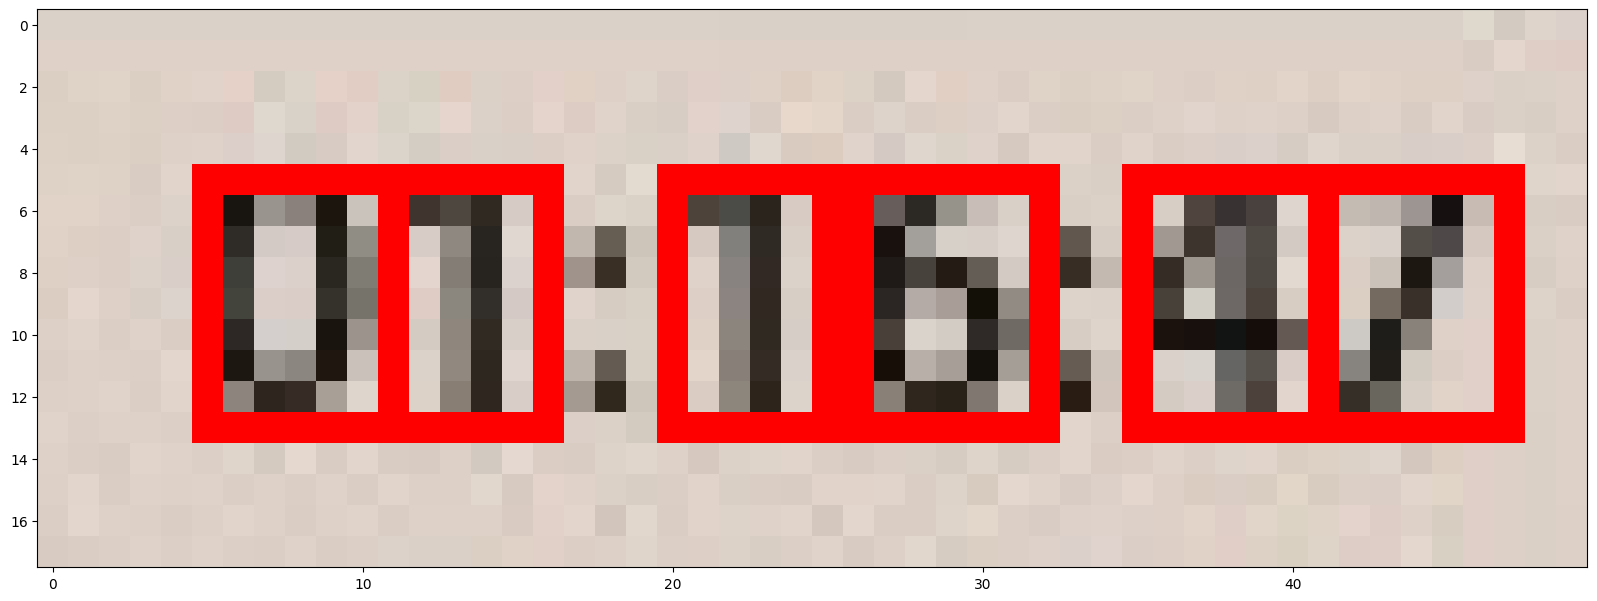

In [129]:
draw_img = cropped_time.copy()
draw_matched_boxes(draw_img, [i.matching_result for i in matched_digits_result])